In [ ]:
# =============================================================================
# Main script to run a full end-to-end example for the abcnre package.
# =============================================================================

import jax
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Imports from abcnre package ---
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import GaussGaussModel

In [ ]:
true_theta = 2.5
epsilon_quantile = 0.05
n_obs = 100

# --- Step 1: Create and Configure Simulator ---
print("--- Step 1: Create and Configure Simulator ---")
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)


gauss_model = GaussGaussModel(mu0=0.0, sigma0=2.0, sigma=0.5)
observed_data = true_theta + gauss_model.sigma * jax.random.normal(subkey, shape=(n_obs,))

simulator = ABCSimulator(
    model=gauss_model,
    observed_data=observed_data,
    quantile_distance=epsilon_quantile
)
print(f"Simulator created with epsilon = {simulator.epsilon:.4f}")

In [2]:
# --- Step 2: Save Simulator Configuration ---
print("\n--- Step 2: Save Simulator Configuration ---")
output_dir = Path("./gauss_example")
output_dir.mkdir(exist_ok=True, parents=True)
simulator_path = output_dir / "gauss_1D_simulator.yml"
simulator.save(simulator_path)
print(f"Simulator config saved to: {simulator_path}")


--- Step 2: Save Simulator Configuration ---
✅ Simulator saved with hash: 6b74249163b0
   - Configuration: gauss_example/gauss_1D_simulator.yml
   - Observed Data: gauss_example/observed_data_6b74249163b0.npy
Simulator config saved to: gauss_example/gauss_1D_simulator.yml


In [3]:
# --- Step 3: Create Network and Training Configuration ---
from abcnre.inference.config import ExperimentConfig, get_experiment_config

print("\n--- Step 3: Create Network Configuration ---")
exp_config = get_experiment_config('default_mlp_plateau')
exp_config.training.num_epochs = 50
exp_config.training.n_samples_per_epoch = 10240
exp_config.training.num_thetas_to_store = 10000

network_config_path = output_dir / "config_mlp_reduce_on_plateau.yml"
exp_config.save(network_config_path)
print(f"Training configuration saved to: {network_config_path}")


--- Step 3: Create Network Configuration ---
Training configuration saved to: gauss_example/config_mlp_reduce_on_plateau.yml


In [4]:
# --- Step 4: Training the Classifier ---
from abcnre.inference.estimator import NeuralRatioEstimator
from abcnre.inference.networks.base import create_network_from_config
print("\n--- Step 4: Training the Classifier ---")

loaded_simulator = ABCSimulator.load(simulator_path)
network = create_network_from_config(exp_config.network.to_dict())
estimator = NeuralRatioEstimator(
    network=network,
    training_config=exp_config.training,
    random_seed=exp_config.random_seed
)

key, train_key = jax.random.split(key)
estimator.train(
    simulator=loaded_simulator,
    output_dir=output_dir,
    num_epochs=exp_config.training.num_epochs,
    n_samples_per_epoch=exp_config.training.n_samples_per_epoch,
    batch_size=exp_config.training.batch_size
)


--- Step 4: Training the Classifier ---
✅ Simulator loaded from: gauss_example/gauss_1D_simulator.yml
Initialized network with 10,753 parameters

--- DEBUG INFO ---
Does epoch_data contain phi_samples? True
Shape of phi_samples: (5120, 1)
--- END DEBUG INFO ---

Epoch 1/50 | Train Loss: 0.6856, Val Loss: 0.6949, Train Acc 55.08%, Val Acc: 48.58%, Learning rate = 0.001000
Epoch 2/50 | Train Loss: 0.6838, Val Loss: 0.6840, Train Acc 71.88%, Val Acc: 55.86%, Learning rate = 0.001000
Epoch 3/50 | Train Loss: 0.6697, Val Loss: 0.6697, Train Acc 70.70%, Val Acc: 78.03%, Learning rate = 0.001000
Epoch 4/50 | Train Loss: 0.6436, Val Loss: 0.6373, Train Acc 72.27%, Val Acc: 81.10%, Learning rate = 0.001000
Epoch 5/50 | Train Loss: 0.5900, Val Loss: 0.6083, Train Acc 80.08%, Val Acc: 66.46%, Learning rate = 0.001000
Epoch 6/50 | Train Loss: 0.5468, Val Loss: 0.5436, Train Acc 76.56%, Val Acc: 79.35%, Learning rate = 0.001000
Epoch 7/50 | Train Loss: 0.5576, Val Loss: 0.5013, Train Acc 70.70%, V

In [5]:
# --- Step 5: Saving All Classifier Artifacts ---
print("\n--- Step 5: Saving All Classifier Artifacts ---")
from abcnre.inference.persistence import save_classifier

final_config_path = save_classifier(
    estimator=estimator,
    simulator=loaded_simulator, # <<< On passe le simulateur pour sauvegarder les dimensions
    output_dir=output_dir,
    filename_base="gauss_1D"
)


--- Step 5: Saving All Classifier Artifacts ---
✅ Classifier saved. Master config: gauss_example/gauss_1D_classifier.yml



--- Step 6: Diagnostics and Visualization ---
Initialized network with 10,753 parameters
✅ Classifier loaded from gauss_example/gauss_1D_classifier.yml
✅ Estimator loaded. Final validation accuracy: 0.809
✅ Simulator loaded from: gauss_example/gauss_1D_simulator.yml
Diagnostic plot saved to gauss_example/posterior_comparison.png


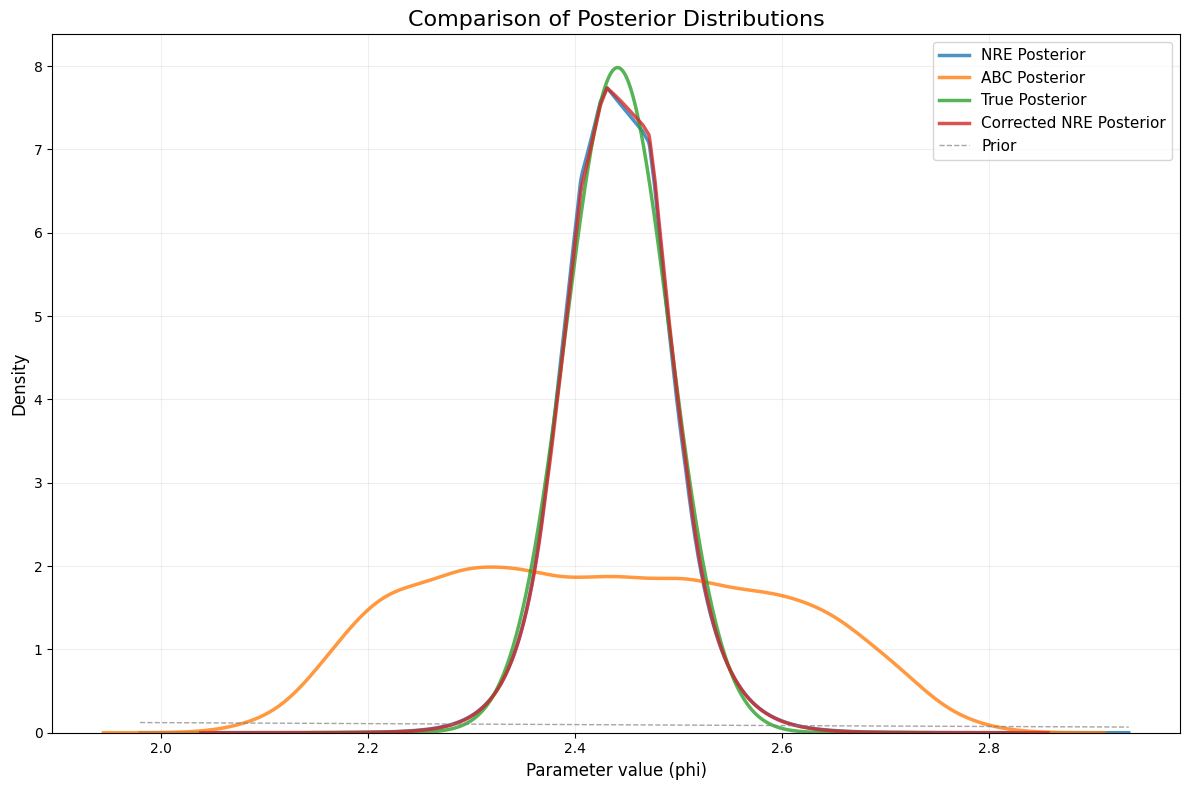


✅ Diagnostics complete.


In [6]:
import jax
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Imports from abcnre package ---

from abcnre.inference.persistence import load_classifier
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unormalized_corrected_nre_pdf
from abcnre.diagnostics.viz import plot_posterior_comparison
from abcnre.simulation import ABCSimulator

output_dir = Path("./gauss_example")
final_config_path = output_dir / "gauss_1D_classifier.yml"
# --- Step 6: Diagnostics and Visualization ---
print("\n--- Step 6: Diagnostics and Visualization ---")
loaded_estimator, abc_phi_samples, metrics = load_classifier(final_config_path)
print(f"✅ Estimator loaded. Final validation accuracy: {metrics.get('final_val_accuracy', -1):.3f}")

min_phi, max_phi = np.min(abc_phi_samples), np.max(abc_phi_samples)
loaded_simulator = ABCSimulator.load(output_dir / "gauss_1D_simulator.yml")
# Get posterior distributions
unnormalized_pdf_func = get_unnormalized_nre_pdf(loaded_estimator, loaded_simulator)
phi_grid, nre_pdf = get_normalized_pdf(unnormalized_pdf_func, initial_bounds=(min_phi, max_phi))

# Get prior for plotting
prior_pdf_values = loaded_simulator.model.prior_pdf(phi_grid)

true_grid, true_pdf = get_normalized_pdf(loaded_simulator.model.get_posterior_distribution(loaded_simulator.observed_data).pdf, initial_bounds=(min_phi, max_phi))

unnormalized_corrected_pdf_func = get_unormalized_corrected_nre_pdf(loaded_estimator, loaded_simulator, phi_samples=abc_phi_samples)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
    initial_bounds=(min_phi, max_phi),
    n_grid_points=10000
)
# Generate the comparison plot
plot_posterior_comparison(
    distributions={'NRE Posterior': (phi_grid, nre_pdf), 'ABC Posterior': abc_phi_samples, 'True Posterior': (true_grid, true_pdf), 'Corrected NRE Posterior': (phi_corrected_grid, unnormalized_corrected_pdf)},
    prior_pdf=(phi_grid, prior_pdf_values),
    save_path=output_dir / "posterior_comparison.png"
)

print("\n✅ Diagnostics complete.")

In [7]:
from abcnre.diagnostics.calibration import run_abc_sbc
from abcnre.diagnostics.viz import plot_sbc_ranks

# --- Step 7: Simulation-Based Calibration (SBC) ---
print("\n--- Step 7: Simulation-Based Calibration (SBC) ---")
import jax
key  = jax.random.PRNGKey(42)
num_posterior_samples = 128  
# sbc_results = run_abc_sbc(
#     key=key,
#     estimator=loaded_estimator,
#     simulator=loaded_simulator,
#     abc_phi_samples=abc_phi_samples,
#     num_sbc_rounds=1000,
#     num_posterior_samples=num_posterior_samples
# )

# Plot SBC ranks
plot_sbc_ranks(sbc_results["ranks"], save_path=output_dir / "sbc_histogram.png", num_posterior_samples=num_posterior_samples)
print("✅ SBC complete. SBC histogram saved.")


--- Step 7: Simulation-Based Calibration (SBC) ---


NameError: name 'sbc_results' is not defined